Introduction text
https://www.analyticsvidhya.com/blog/2018/09/reinforcement-multi-armed-bandit-scratch-python/
    

In [633]:
# libraries to import
import numpy as np
import matplotlib.pyplot as plt

In [667]:
# useful functions
def bar_plot(x_values, y_values, x_label="", y_label="", title=""):

    # Create bar plot
    plt.bar(x_values, y_values)

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    return plt
    
def bar_plot_explore_then_exploit(x_values, y_values, x_label="", y_label="", title="", true_probs=[]):
    plt = bar_plot(x_values, y_values, x_label, y_label, title)
    
    for i, p in enumerate(true_probs):
        plt.axhline(y=p*max(y_values), color='red', linestyle='--')
        plt.text(i, p*max(y_values), f'{p:.0%}', ha='center', va='bottom')
    
    return plt
    

def line_plot(y_values, x_values=None, x_label="", y_label="", title=""):
    
    # If x_values is not specified, use range of length of y_values
    if x_values is None:
        x_values = range(len(y_values))
    
    # Create line plot
    plt.plot(x_values, y_values)
    
    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    
    return plt
    
def multiple_lines_plot(x_values, y_values_list, labels=[], x_label="", y_label="", title=""):

    # Create multiple lines plot
    for y_values, l in zip(y_values_list, labels):
        plt.plot(x_values, y_values, label='l')
        plt.legend(labels)

        
    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Show the plot
    plt.show()
    
def sub_optimal_arm_chosen_plot(p, actions):
    optimal_arm = np.argmax(p)
    sub_optimal_arm_chosen = np.cumsum((actions != optimal_arm).astype(int))

    plt = line_plot(y_values=sub_optimal_arm_chosen, x_label="Time", y_label="Total nb of times sub-optimal arm was chosen", title="# times sub-optimal arm was chosen")
    return plt
    
def money_stats(initial_money, price_per_play, n_trials, reward, rewards):

    money_invested = n_trials * price_per_play
    money_gained = np.sum(rewards) * reward

    money_diff = money_gained - money_invested
    money_left = initial_money + money_diff

    print("Money initially : " + str(initial_money))
    print("Money invested : " + str(money_invested))
    print("Money gained : " + str(money_gained))
    print("Money difference : " + str(money_diff))
    print("Money left : " + str(money_left))

def money_plot(rewards, price_per_play):
    diff_per_play = np.array(rewards).reshape((len(rewards), 1)) - np.ones((len(rewards), 1)) * price_per_play
    plt = line_plot(y_values=np.cumsum(diff_per_play), x_label="Time", y_label="Money difference", title="Money gain/loss over time")

    return plt
    
def money_plot_explore_then_exploit(rewards, price_per_play, changes):
    plt = money_plot(rewards, price_per_play)
    
    plt = add_vertical_lines(plt, changes)
    
    return plt

def add_vertical_lines(plt, changes):
    percent_10_below = plt.ylim()[0] - 0.1 * plt.ylim()[1]
    
    # Add vertical dashed lines
    for step_arm in changes: 
        plt.axvline(x=step_arm[0], linestyle='--', color='red')
        plt.text(step_arm[0], percent_10_below, 'Arm ' + str(step_arm[1]), rotation=90, va='top')
        
    return plt
    

def regret_plot_explore_then_exploit(y_values, x_values=None, title="", changes=[]):
    plt = line_plot(y_values, x_values, "Time", "Regret", title)
    plt = add_vertical_lines(plt, changes)
    return plt
    

def show_plot(plt):
    plt.show()    
    
# Define the regret function
def regret(actions, p):
    actions_array = actions.reshape(len(actions), 1).astype(int)
    return np.cumsum(np.max(p) - p[actions_array])

def plot_estimate_interval(n_arms, wins, losses, c):
    # Calculate upper and lower confidence bounds for each arm
    p = np.zeros(n_arms)
    lower_bounds = np.zeros(n_arms)
    upper_bounds = np.zeros(n_arms)
    for i in range(n_arms):
        if wins[i] + losses[i] > 0:
            p[i] = wins[i] / (wins[i] + losses[i])
            lower_bounds[i] = p[i] - c / np.sqrt(wins[i] + losses[i])
            upper_bounds[i] = p[i] + c / np.sqrt(wins[i] + losses[i])
        else:
            p[i] = 0
            lower_bounds[i] = 0
            upper_bounds[i] = 0
    
    # Plot bar plot with estimate interval
    x = np.arange(n_arms)
    fig, ax = plt.subplots()
    ax.bar(x, p, align='center', alpha=0.5)
    ax.vlines(x, lower_bounds, upper_bounds, colors='r', linewidth=2)
    ax.set_xlabel('Arm')
    ax.set_ylabel('Probability Estimate')
    ax.set_title('Estimate Interval')
    plt.show()

In [668]:
# Total number of arms
n_arms = 6

# probabilities
true_probs = np.random.rand(n_arms)
highest_prob_arm = np.argmax(true_probs)

print("The arm with the highest probability is at index : " + str(highest_prob_arm) + " \nits probability is : " + str(true_probs[highest_prob_arm]))


The arm with the highest probability is at index : 5 
its probability is : 0.9580972749323309


In [669]:
initial_money = 5000
price_per_play = 0.5
reward = 1
loss = 0

## Theoretical success rate of each arm

In the bar chart below, we can see the probability of success for each arm, this probability of sucess has been generated randomly.

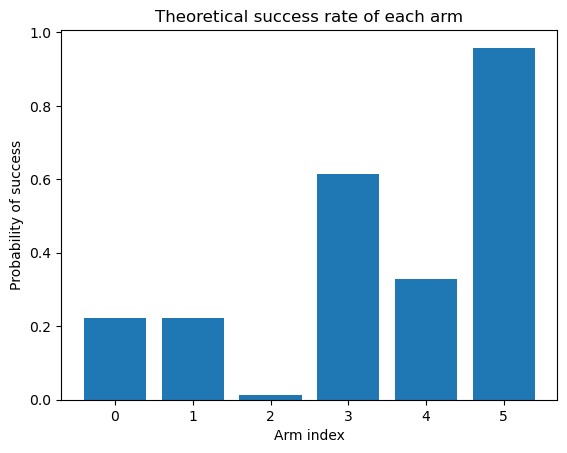

In [670]:
show_plot(bar_plot(x_values = range(len(true_probs)), y_values = true_probs, x_label="Arm index", y_label="Probability of success", title="Theoretical success rate of each arm"))

In [671]:
print("True probabilites for each arm : ")
print(true_probs)

True probabilites for each arm : 
[0.22148978 0.22316455 0.01402926 0.6139736  0.32940789 0.95809727]


# Strategy 1 : Explore then exploit

For this, we explore by playing a 100 times each arm, then depending on which one got us the most wins, we decide to commit to it.

In [672]:
# variables to set
n_steps = 10000

def explore_then_exploit_naive(n_steps, n_arms, explore_fraction, p):
    if n_steps * price_per_play > initial_money:
        raise Exception("Not enough money to play ! Decrease the number of trials")
        
    if explore_fraction > 1.0:
        raise Exception("Explore fraction shouldn't be more than 1 !")
    
    explore_per_arm = int(np.floor(n_steps * explore_fraction / n_arms))
    n_steps_explore = explore_per_arm * n_arms
    n_steps_exploit = n_steps - n_steps_explore
    
    # arm chosen and reward corresponding
    actions = np.zeros(n_steps)
    rewards = np.zeros(n_steps)
    # list of tuples (step, arm)
    changes = []
    
    results_all_arms_end_of_explore = np.zeros((n_arms, explore_per_arm))

    # explore
    for arm_index in range(n_arms):
        results_for_arm = np.random.choice([0, 1], size=(1, explore_per_arm), p=[1-float(p[arm_index]), float(p[arm_index])])
        results_all_arms_end_of_explore[arm_index, :] = results_for_arm
        start = explore_per_arm * arm_index
        end = explore_per_arm * (1+arm_index)
        rewards[start:end] = results_for_arm
        actions[start:end] = np.ones(explore_per_arm) * arm_index
        changes.append((start, arm_index))
        
    end_of_explore_results = np.sum(results_all_arms_end_of_explore, axis=1)
    
    # exploit
    best_arm = np.argmax(end_of_explore_results)
    result_for_exploited_arm = np.random.choice([0, 1], size=(1, n_steps_exploit), p=[1-float(p[best_arm]), float(p[best_arm])])
    rewards[n_steps_explore:] = result_for_exploited_arm
    actions[n_steps_explore:] = np.ones(n_steps_exploit) * best_arm
    changes.append((n_steps_explore, best_arm))

    return explore_per_arm, results_all_arms_end_of_explore, end_of_explore_results, actions, rewards, changes

In [673]:
# Running the algorithm
explore_per_arm, results_all_arms_end_of_explore, end_of_explore_results, actions, rewards, changes = explore_then_exploit_naive(n_steps, n_arms, 0.3, p=true_probs)

## Number of wins as the number of pulls for each arm increases

In the plot below, we can see the total number of wins as we pull the arm more and more. We can see that as the number of pulls increases, the difference in successes grows between the arms. Which is understandable since according to the law of large numbers, as the number of pulls increases we get a success rate that approaches the theoretical success rate of each arm.

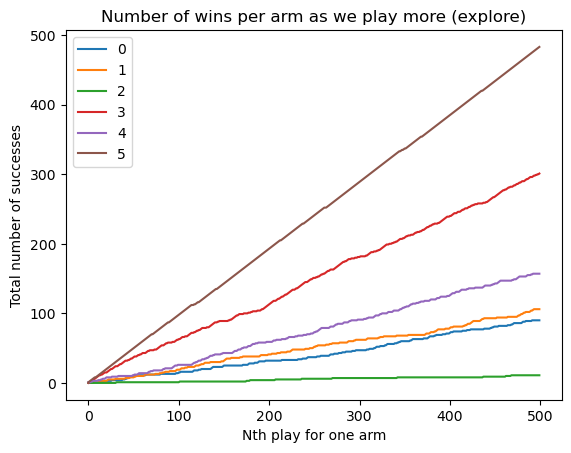

In [674]:
cum_sum_results_all_arms = np.cumsum(results_all_arms_end_of_explore, axis=1)
multiple_lines_plot(x_values=range(explore_per_arm), y_values_list=cum_sum_results_all_arms, labels=range(n_arms), x_label="Nth play for one arm", y_label="Total number of successes", title="Number of wins per arm as we play more (explore)")

## Results at the end of explore step

In the bar chart below, you can see which arm has won the most, we can also divide by the total number of plays to see the empirical probabilities of success.

In [675]:
end_of_explore_results

array([ 90., 106.,  11., 301., 157., 483.])

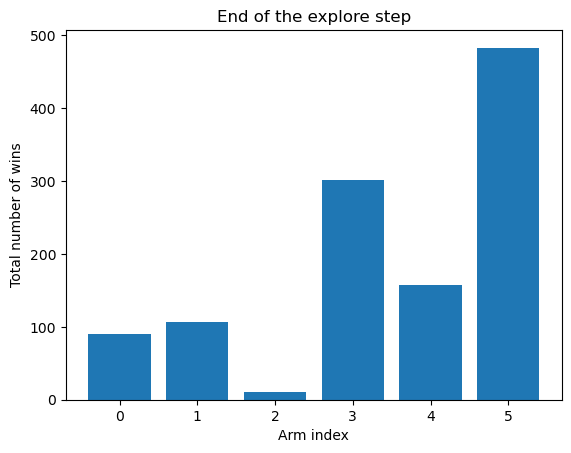

In [676]:
show_plot(bar_plot(x_values=range(len(end_of_explore_results)), y_values=end_of_explore_results, x_label="Arm index", y_label="Total number of wins", title="End of the explore step"))

In [677]:
index_with_most_wins = np.argmax(end_of_explore_results)
print("The arm that won the most at the end of exploration phase is : " + str(index_with_most_wins) + " with " + str(int(end_of_explore_results[index_with_most_wins])) + " wins.")

The arm that won the most at the end of exploration phase is : 5 with 483 wins.


In [678]:
end_of_explore_results

array([ 90., 106.,  11., 301., 157., 483.])

### Comparison theoretical probabilities vs empirical probabilities

The horizontal red lines represent the true probability of success. We see that there are some gaps between the empirical (vertical bars in blue) and the theoretical values (horizontal lines in red).

If we increase the number of exploration steps for each arm, the gap between the empirical and theoretical values will decrease.

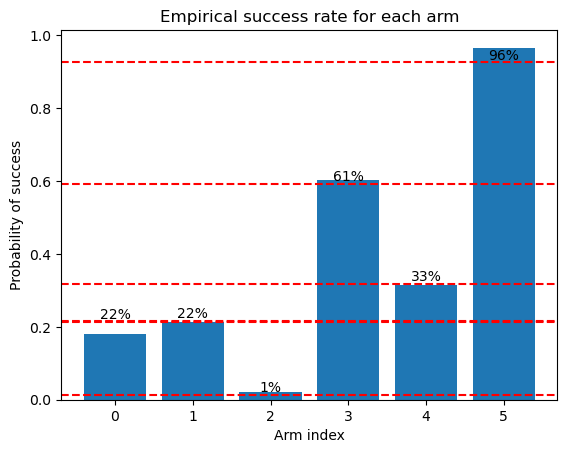

In [679]:
show_plot(bar_plot_explore_then_exploit(x_values=range(len(end_of_explore_results)), y_values=end_of_explore_results / results_all_arms_end_of_explore.shape[1] , x_label="Arm index", y_label="Probability of success", title="Empirical success rate for each arm", true_probs=true_probs))

## Money variation

In the plot below, we can see the variation in money as a function of time t (t representing the number of pulls).

Since we plotted vertical dashed lines in red that represents a switch in arm, we see that when we choose an arm with low success rate, the slope becomes low and sometimes even negative (we loose more money than we gain !!!).

When choosing an arm with high success rate, the slope is more positive (we win more money than we spend pulling the arm).

Overall, after the explore phase, when we decide to commit to the arm with highest empirical success rate, we see that the total money gain goes up.

Money initially : 5000
Money invested : 5000.0
Money gained : 7845.0
Money difference : 2845.0
Money left : 7845.0


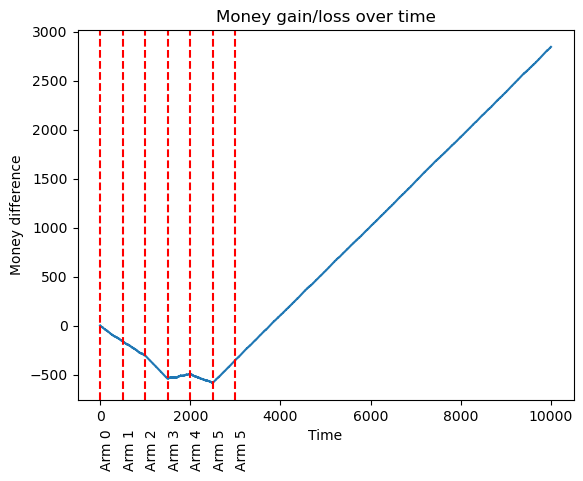

In [680]:
money_stats(initial_money, price_per_play, n_steps, reward, rewards)

show_plot(money_plot_explore_then_exploit(rewards, price_per_play, changes))

## Regret

In the plot below we see the regret, the slope is 0 when we pick the best arm (the one with highest probability of success).

The slope becomes greater when picking an arm with lower success rate.

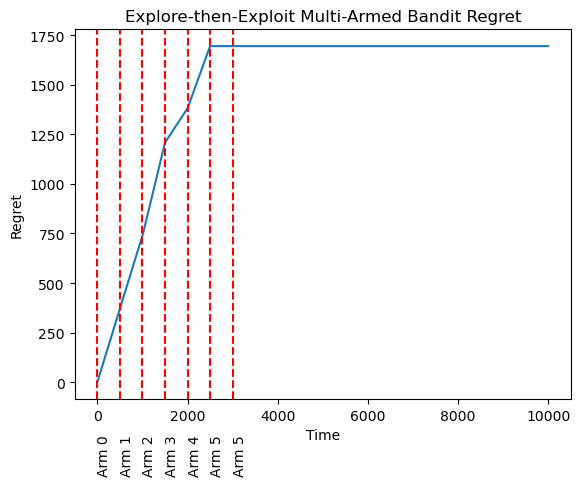

In [681]:
regret_vals = regret(actions, true_probs)
show_plot(regret_plot_explore_then_exploit(y_values=regret_vals, title="Explore-then-Exploit Multi-Armed Bandit Regret", changes=changes))

## Suboptimal arm chosen

In the plot below we see how the number of times we choose a suboptimal arm varies. At the end of the explore case, we pick (in most cases and if the exploration phase was large enough) the optimal arm and so the number total do not increase. 

This plot is somewhat similar to the regret plot in the way that the slope becomes 0 when playing the optimal arm.

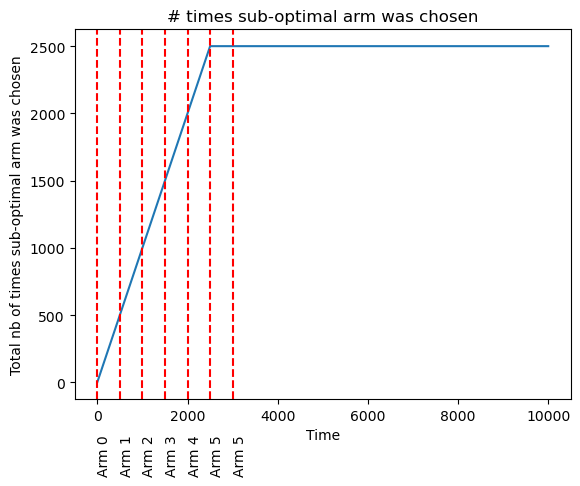

In [682]:
show_plot(add_vertical_lines(sub_optimal_arm_chosen_plot(p=true_probs, actions=actions), changes))

# Strategy 2 : Explore then exploit - by elimination

In the previous strategy, we say decide initially how much we are going to play. 

If we analyse the graph of exploring, we can see that after some plays, we can notice a significant difference in success rate for each arm.

Therefore, to avoid pulling an arm that performs very bad again and again, we can eliminate it the worst performing arm after a given number of plays so that we can avoid wasting any more money on that particular arm.

So the algorithm works as follow:

We decide on the number of rounds of eliminations we want, and the amount of time each arm has to be pulled. At the end of the round, we eliminate the worst performing arm and therefore wasting money on it.

In [683]:
def total_explore_arm_pulls_for_elimination_algo(n_arms, n_rounds, round_steps_per_arm):
    total = 0
    for round_i in range(n_rounds):
        total = total + n_arms - round_i
    return total * round_steps_per_arm

In [684]:
n_trials = 10000
    
def explore_then_exploit_elimination(n_steps, n_arms, n_rounds, round_steps_per_arm, p):
    n_steps_explore = total_explore_arm_pulls_for_elimination_algo(n_arms, n_rounds, round_steps_per_arm) 
    n_steps_exploit = n_steps - n_steps_explore
    
    if n_steps * price_per_play > initial_money:
        raise Exception("Not enough money to play ! Decrease the number of trials")
        
    if n_rounds >= n_arms:
        raise Exception("Number of rounds should be strictly lesser than the number of arms")

    if n_steps < n_steps_explore:
        raise Exception("Increase number of trials, or decrease the number of rounds or the number of steps per arm for each round")
    
    end_of_explore_total = np.zeros(n_arms)
    poor_performing_arms = []
    
    # contains (arm, step, total nb of pulls) for elimination history
    eliminations = []
    
    # contains (arm, step)
    changes = []

    actions = np.zeros(n_steps)
    rewards = np.zeros(n_steps)

    results_all_arms_end_of_explore = np.zeros((n_arms, 0))
    results_all_arms = np.zeros((n_arms, 0))
    
    # stores the total nb of arms visited
    counter_arm = 0

    # explore
    for i in range(n_rounds):

        results_all_arms = np.zeros((n_arms, round_steps_per_arm))

        for arm_index in range(n_arms):
            # doesn't exist in the poor performing list
            if poor_performing_arms.count(arm_index) == 0:
                results_all_arms[arm_index, :] = np.random.choice([0, 1], size=(1, round_steps_per_arm), p=[1-float(p[arm_index]), float(p[arm_index])])
                start = round_steps_per_arm * counter_arm
                end = round_steps_per_arm * (1+counter_arm)
                actions[start:end] = np.ones(round_steps_per_arm) * arm_index
                rewards[start:end] = results_all_arms[arm_index, :]
                changes.append((start, arm_index))
                counter_arm = counter_arm + 1
        
        end_of_round_results = np.sum(results_all_arms, axis=1)
        end_of_explore_total = end_of_explore_total + end_of_round_results

        index_with_least_wins = np.argsort(end_of_explore_total, axis=0)[i]
        
        poor_performing_arms.append(index_with_least_wins)
        eliminations.append((index_with_least_wins, round_steps_per_arm * counter_arm, results_all_arms_end_of_explore.shape[1] + round_steps_per_arm))

        results_all_arms_end_of_explore = np.concatenate((results_all_arms_end_of_explore, results_all_arms), axis=1)
        
        if i == n_rounds - 1:
            results_all_arms = np.concatenate((results_all_arms, results_all_arms_end_of_explore), axis=1)
            
        
    # exploit
    best_arm = np.argmax(end_of_explore_total)
    result_for_exploited_arm = np.random.choice([0, 1], size=(1, n_steps_exploit), p=[1-float(p[best_arm]), float(p[best_arm])])
    rewards[n_steps_explore:] = result_for_exploited_arm
    actions[n_steps_explore:] = np.ones(n_steps_exploit) * best_arm
    changes.append((n_steps_explore, best_arm))
    

    # reshape
    return results_all_arms_end_of_explore, end_of_explore_total, results_all_arms, eliminations, actions, rewards, changes

In [685]:
# Running the algorithm
results_all_arms_end_of_explore, end_of_explore_total, results_all_arms, eliminations, actions, rewards, changes = explore_then_exploit_elimination(n_trials, n_arms, n_arms - 1, 200, p=true_probs)

## Exploration phase

During the exploration phase, every round, we pull each arm for a given amount.

After pulling all arms, we look at which one has performed the worst up until now. We eliminate the lowest performing one to avoid pulling it again in the next rounds. We continue up until we finish all rounds.

At the end, we select the arm that has performed the best (the one who has the highest empirical success rate) and we spend the rest of our money on it.

### Number of wins as the number of pulls for each arm increases

In the plot below, we can see the total number of wins as we pull the arm more and more. We can see that as the number of pulls increases, the difference in successes grows between the arms.

However, we can see that at the end of each round, the lowest performing arm is eliminated. This is why the slope becomes equal to zero (the total number of successes stops increasing) since we stop pulling those arms.

In [686]:
i = 1
for arm_step in eliminations:
    print("Round " + str(i) + ", The arm that won the least is : " + str(arm_step[0]) + " with " + str(int(end_of_explore_total[arm_step[0]])) + " wins.")
    i = i + 1

Round 1, The arm that won the least is : 2 with 3 wins.
Round 2, The arm that won the least is : 0 with 98 wins.
Round 3, The arm that won the least is : 1 with 152 wins.
Round 4, The arm that won the least is : 4 with 255 wins.
Round 5, The arm that won the least is : 3 with 601 wins.


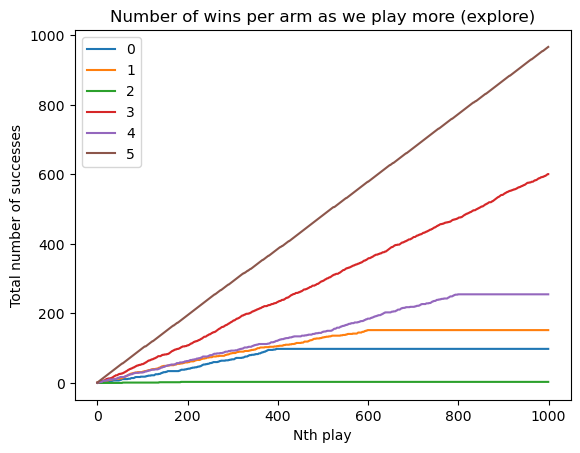

In [687]:
cum_sum_results_all_arms = np.cumsum(results_all_arms_end_of_explore, axis=1)

multiple_lines_plot(x_values=range(results_all_arms_end_of_explore.shape[1]), y_values_list=cum_sum_results_all_arms, labels=range(n_arms), x_label="Nth play", y_label="Total number of successes", title="Number of wins per arm as we play more (explore)")

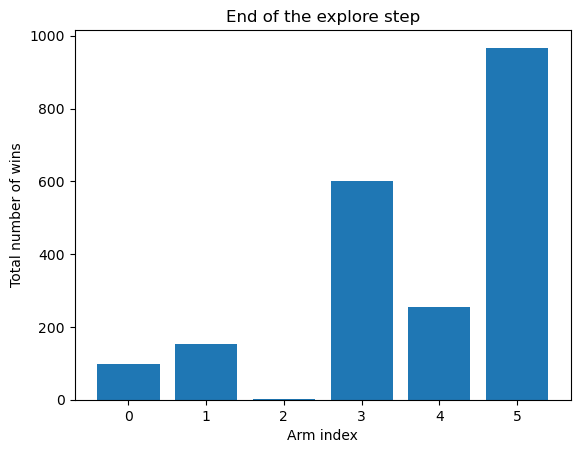

In [688]:
show_plot(bar_plot(x_values=range(len(end_of_explore_total)), y_values=end_of_explore_total, x_label="Arm index", y_label="Total number of wins", title="End of the explore step"))

In [690]:
index_with_most_wins = np.argmax(end_of_explore_total)
print("The arm that won the most at the end of exploration phase is : " + str(index_with_most_wins) + " with " + str(int(end_of_explore_total[index_with_most_wins])) + " wins.")

The arm that won the most at the end of exploration phase is : 5 with 967 wins.


In [691]:
end_of_explore_total

array([ 98., 152.,   3., 601., 255., 967.])

### Comparison theoretical probabilities vs empirical probabilities¶

The horizontal red lines represent the true probability of success. 

We see that at the end of the exploration phase, we have a pretty good approximation for the probability of success for the best performing arms. This is because we pulled them more than the ones that got eliminated. 

There are some gaps between the empirical (vertical bars in blue) and the theoretical values (horizontal lines in red).

In [692]:
def empirical_probabilities_with_eliminations(results_all_arms_end_of_explore, end_of_explore_total, eliminations):
    empirical_probabilities = end_of_explore_total / results_all_arms_end_of_explore.shape[1]
    for arm_step in eliminations:
        empirical_probabilities[arm_step[0]] = end_of_explore_total[arm_step[0]] / arm_step[2]
    return empirical_probabilities  

Empirical probabilities : 
[0.245      0.25333333 0.015      0.601      0.31875    0.967     ]


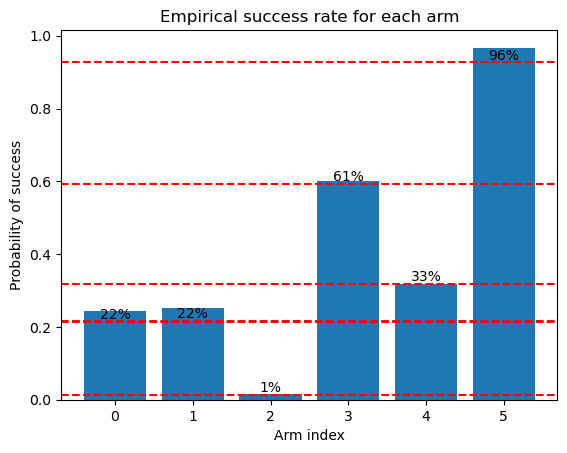

In [693]:
empirical_probabilities = empirical_probabilities_with_eliminations(results_all_arms_end_of_explore, end_of_explore_total, eliminations)

print("Empirical probabilities : ")
print(empirical_probabilities)

show_plot(bar_plot_explore_then_exploit(x_values=range(n_arms), y_values=empirical_probabilities , x_label="Arm index", y_label="Probability of success", title="Empirical success rate for each arm", true_probs=true_probs))

## Money variation
In the plot below, we can see the variation in money as a function of time t (t representing the number of pulls).

Since we plotted vertical dashed lines in red that represents a switch in arm, we see that when we choose an arm with low success rate, the slope becomes low and sometimes even negative (we loose more money than we gain !!!).

When choosing an arm with high success rate, the slope is more positive (we win more money than we spend pulling the arm).

Overall, after the explore phase, when we decide to commit to the arm with highest empirical success rate, we see that the total money gain goes up.

Money initially : 5000
Money invested : 5000.0
Money gained : 7806.0
Money difference : 2806.0
Money left : 7806.0


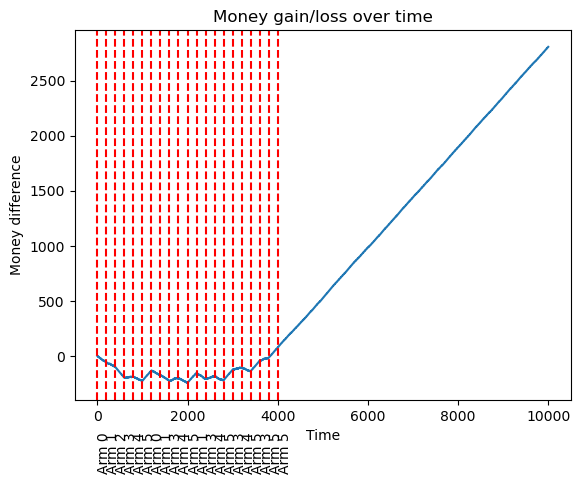

In [694]:
money_stats(initial_money, price_per_play, n_steps, reward, rewards)
show_plot(money_plot_explore_then_exploit(rewards, price_per_play, changes))

## Regret

In the plot below we see the regret, the slope is 0 when we pick the best arm (the one with highest probability of success).

The slope becomes greater when picking an arm with lower success rate.

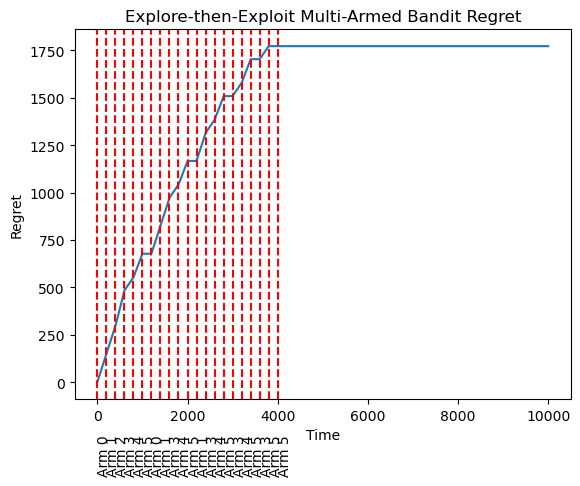

In [695]:
regret_vals = regret(actions, true_probs)
show_plot(regret_plot_explore_then_exploit(y_values=regret_vals, title="Explore-then-Exploit Multi-Armed Bandit Regret", changes=changes))

## Suboptimal arm chosen

In the plot below we see how the number of times we choose a suboptimal arm varies. At the end of the explore case, we pick (in most cases and if the exploration phase was large enough) the optimal arm and so the number total do not increase.

This plot is somewhat similar to the regret plot in the way that the slope becomes 0 when playing the optimal arm.

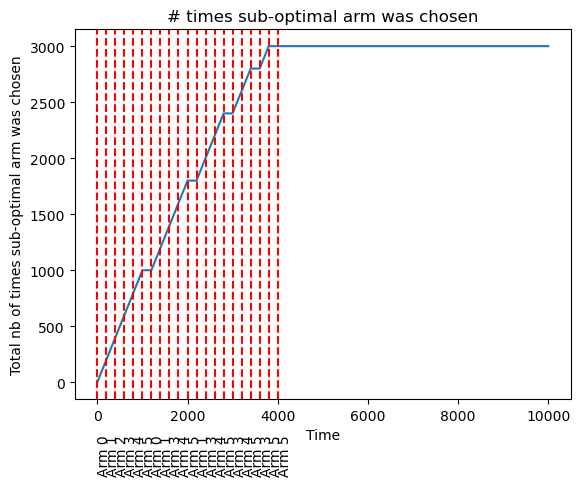

In [696]:
show_plot(add_vertical_lines(sub_optimal_arm_chosen_plot(p=true_probs, actions=actions), changes))

# Strategy 3 : Epsilon-Greedy Algorithm

In the previous strategy, we say decide initially how much we are going to play. This can become a problem in situations where we have limited resources. 
A strategy would be to assign weights to each arm and recalculate every time we try one.

The epsilon-greedy algorithm is a simple algorithm for exploring and exploiting a set of options or actions in a reinforcement learning problem or a multi-armed bandit problem. The algorithm works as follows:

1. Initialize a set of action-value estimates Q(a) for each action a.

2. For each time step t:

    a. With probability epsilon, select a random action.

    b. Otherwise, select the action with the highest action-value estimate.

    c. Take the selected action and observe the reward r.

    d. Update the action-value estimate Q(a) for the selected action using the observed reward r.

3. Repeat step 2 for a fixed number of time steps or until convergence.

In [697]:
n_trials = 10000
initial_money = 5000

# check we have enough money
if n_trials * price_per_play > initial_money:
    raise Exception("You don't have enough money initially !")

In [698]:
def epsilon_greedy(n_trials, n_arms, epsilon, p):
    
    # check we have enough money
    if n_trials * price_per_play > initial_money:
        raise Exception("You don't have enough money initially !")
        
    Q = np.zeros(n_arms) # Action-value estimates
    N = np.zeros(n_arms) # Number of times each action is taken

    actions = np.zeros(n_trials) # arm picked
    rewards = np.zeros( n_trials) # result of action 

    for t in range(n_trials):
        
        # pick an action
        if np.random.rand() < epsilon:
            action = np.random.choice(n_arms)
        else:
            action = np.argmax(Q)
        
        reward = np.random.binomial(1, p[action])
        
        # saving
        actions[t] = action
        rewards[t] = reward
        
        N[action] += 1
        Q[action] += (reward - Q[action]) * (1 / N[action])

    return actions, rewards, N, Q


In [699]:
# Running the algorithm
actions, rewards, N, Q = epsilon_greedy(n_trials, n_arms, epsilon=0.01, p=true_probs)

## Results at the end of epsilon-greedy
In the bar chart below, you can see which arm has won the most, we can also divide by the total number of plays to see the empirical probabilities of success.

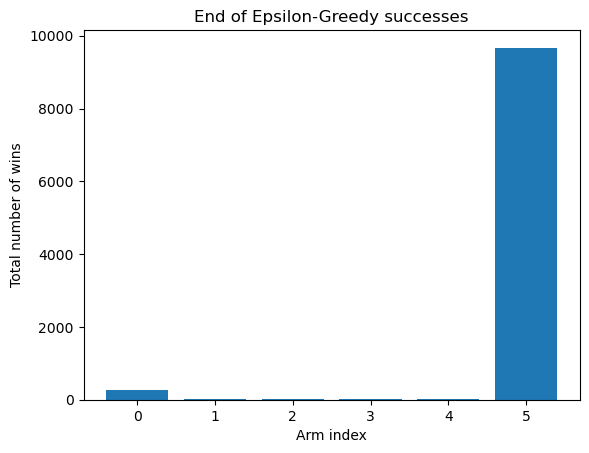

In [700]:
show_plot(bar_plot(x_values=range(len(N)), y_values=N, x_label="Arm index", y_label="Total number of wins", title="End of Epsilon-Greedy successes"))

In [701]:
print("Total successes for each arm at the end of epsilon-greedy : ")
print(N)

Total successes for each arm at the end of epsilon-greedy : 
[ 267.   14.   16.   16.   17. 9670.]


## Comparison theoretical probabilities vs empirical probabilities¶

The horizontal red lines represent the true probability of success.

We see that we have a pretty good approximation for the probability of success for the best performing arms. This is because we pulled them more often than the ones that got eliminated.

This is because, as we pull the arms, we get a better approximations for the success rates for the arms. That means that with a probability 1-epsilon, we will draw the one that has the highest success rate among all other arms. 

This is why the higher success rate arms have better approximation (the gap between the empirical values - vertical blue bars - and the theoretical values - horizontal red lines - is smaller than the gap for low success rate arms). This is because since they win less, we are less likely to pull them again and hence get a better approximation.

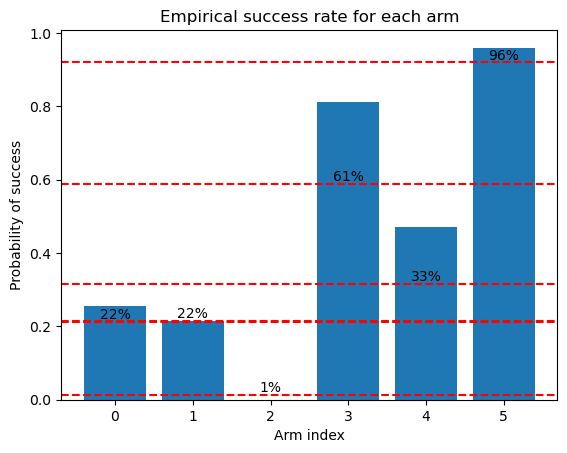

In [702]:
show_plot(bar_plot_explore_then_exploit(x_values=range(n_arms), y_values=Q , x_label="Arm index", y_label="Probability of success", title="Empirical success rate for each arm", true_probs=true_probs))

## Money variation

In the plot below, we can see the variation in money as a function of time t (t representing the number of pulls).

When choosing an arm with high success rate, the slope is more positive (we win more money than we spend pulling the arm).

At the start, since arms are pulled randomly until we get data, the slope might become negative.

The epsilon is a tradeoff. A big one means that will find out the best arm faster than if epsilon is smaller. However, in the long run, we will keep picking an arm at random with probability epsilon even after a very long amount of pulls, which makes it inefficient.

With a smaller epsilon, we might lose money in the beginning, eg: picks as the first arm randomly one with probability of success 1%, if it wins, we will pull this one again and again each time with probability 1-epsilon. Until another arm with higher success rate wins at least more than that one.

This might lead to losing money in the beginning but will bring highest return if the number of pulls increases.

Money initially : 5000
Money invested : 5000.0
Money gained : 9371.0
Money difference : 4371.0
Money left : 9371.0


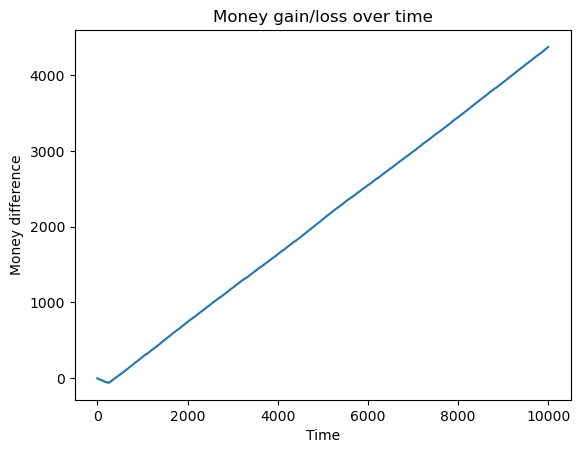

In [703]:
# Calculating money    
money_stats(initial_money, price_per_play, n_trials, reward, rewards)
show_plot(money_plot(rewards, price_per_play))

## Regret

In the plot below we see the regret, the slope is 0 when we pick the best arm (the one with highest probability of success).

There are 2 main parts in the plot :

a) The beginnning, in this phase, we are picking one arm at random, and we will need to wait until the best arm has succeeded more than all other arms. This phase might take longer depending on the value of epsilon.

A smaller value of epsilon will lead to a longer first phase of "trials/exploration", while a bigger value of epsilon will lead to a shorter "trial/exploration phase".

b) After the first phase, we normally have good estimates for each success rate of the arms, especially those who have a higher probability of success. Therefore, we will pick more often the best arm. And occasionally we pick one at random with probability epsilon.

This is the reason why we have a plot that resembles a logarithmic function and we don't have a flat line for the second part, unlike the explore-then-exploit algorithms.

In [704]:
# Compute the regret
regret_vals = regret(actions, true_probs)

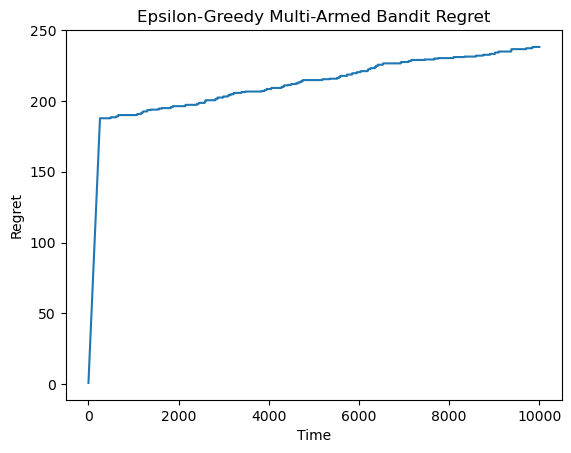

In [705]:
# Plot the regret
show_plot(line_plot(y_values=regret_vals, x_label="Time", y_label="Regret", title="Epsilon-Greedy Multi-Armed Bandit Regret"))

## Suboptimal arm chosen

In the plot below we see how the number of times we choose a suboptimal arm varies. 

The reasoning is the same as with the regret plot, there are mainly 2 phases, the exploration part and the exploit part.

When the number of success for the best arm has finally exceeded those of the other arms, we can see that the optimal arm is chosen every time with probability 1-epsilon.

It is not a flat line because epsilon-greedy is designed in such a way that an arm is always picked randomly with probability epsilon.

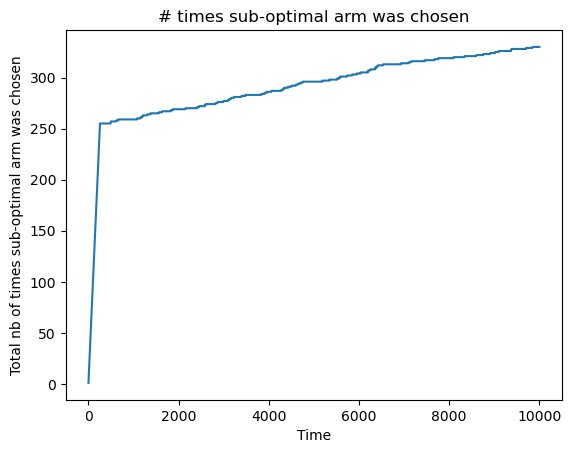

In [706]:
show_plot(sub_optimal_arm_chosen_plot(p=true_probs, actions=actions))

# Strategy 4 : Explore then exploit

In [427]:
c = 0.9 # 0.8 is good
n_trials = 10000
initial_money = 5000

if n_trials * price_per_play > initial_money:
    raise Exception("Not enough money to play ! Decrease the number of trials")

In [428]:
def elimination_confidence_bound_algorithm(n_arms, n_steps, c, p):
    # Initialize variables
    wins = np.zeros(n_arms)
    losses = np.zeros(n_arms)
    upper_bounds = np.ones(n_arms) * float('inf')
    lower_bounds = np.ones(n_arms) * float('-inf')
    p_hat = np.zeros(n_arms)
    selected_arms = np.zeros(n_steps)
    rewards = np.zeros(n_steps)
    eliminated_arms = []
    
    counter = 0
    
    for step in range(n_steps):
        # Calculate upper confidence bounds for each arm
        for i in range(n_arms):
            if eliminated_arms.count(i) == 0:
                if wins[i] + losses[i] > 0:
                    p_hat[i] = wins[i] / (wins[i] + losses[i])
                    upper_bounds[i] = p_hat[i] + c / np.sqrt(wins[i] + losses[i])
                    lower_bounds[i] = p_hat[i] - c / np.sqrt(wins[i] + losses[i])
        
        for selected_arm in range(n_arms):

            if eliminated_arms.count(selected_arm) == 0:
                counter = counter + 1
                selected_arms[counter] = selected_arm

                # Simulate play for each arm and update wins and losses
                if np.random.rand() < p[selected_arm]:  # simulate win with probability p_i
                    wins[selected_arm] += 1
                    rewards[counter] = 1
                else:
                    losses[selected_arm] += 1
                    rewards[counter] = 0
                
            if(counter == n_steps-1): 
                return selected_arms, rewards, wins, losses
            
        # todo ask if taking highest upperbound is better ?
        highest_p_hat = np.argmax(p_hat)
        

        # Check if there is only one arm left
        if np.sum(upper_bounds != float('-inf')) >= 1:
            # Check to eliminate arm
            for i in range(n_arms):
                if eliminated_arms.count(i) == 0:
                    if upper_bounds[i] < lower_bounds[highest_p_hat]:    
                        print("eliminated arm : " + str(i) + ", at step : " + str(step))
                        eliminated_arms.append(i)
                                  
    # Return selected arms at each step
    return selected_arms, rewards, wins, losses

In [429]:
selected_arms, rewards, wins, losses = elimination_confidence_bound_algorithm(n_arms, n_trials, c, true_probs)

print(len(selected_arms))

eliminated arm : 1, at step : 4
eliminated arm : 4, at step : 4
eliminated arm : 5, at step : 7
eliminated arm : 0, at step : 19
eliminated arm : 2, at step : 43
10000


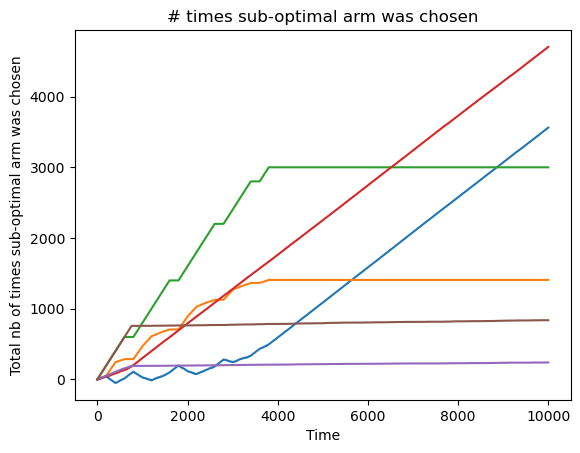

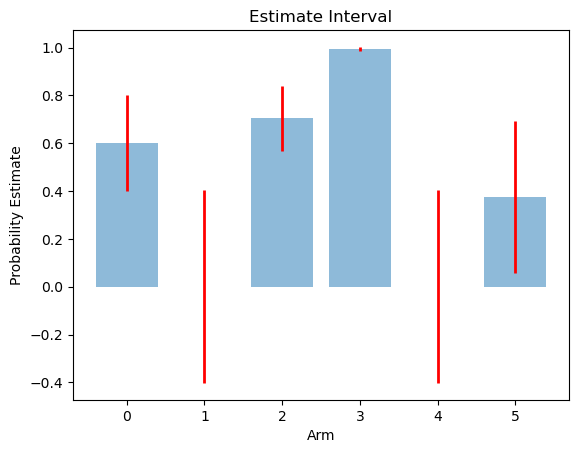

(10000,)
9903.0


In [430]:
# estimate interval at the end 
plot_estimate_interval(n_arms, wins, losses, c)

print(selected_arms.shape)
print(np.sum(wins))

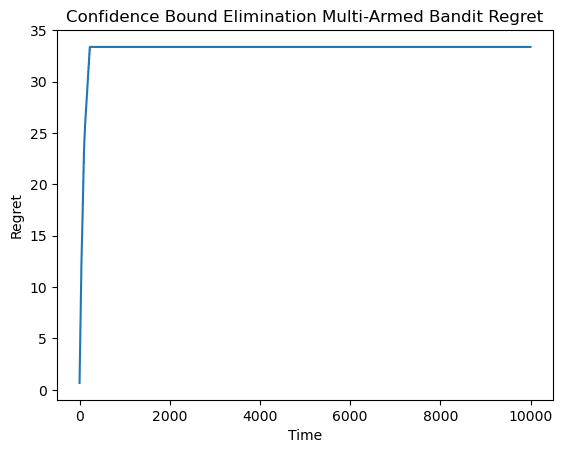

In [269]:
# Compute the regret
regret_vals = regret(selected_arms, true_probs)
# Plot the regret
# line_plot(y_values=regret_vals, x_label="Time", y_label="Regret", title="Confidence Bound Elimination Multi-Armed Bandit Regret")
line_plot(y_values=regret_vals, x_label="Time", y_label="Regret", title="Confidence Bound Elimination Multi-Armed Bandit Regret")

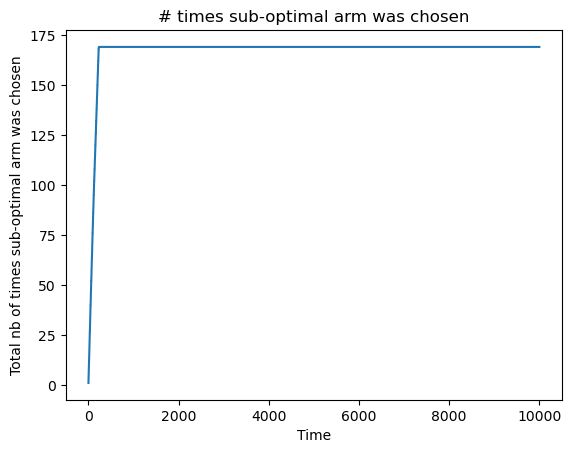

In [270]:
sub_optimal_arm_chosen_plot(p=true_probs, actions=selected_arms)

In [271]:
money_stats(initial_money, price_per_play, n_trials, reward, rewards)

Money initially : 5000
Money invested : 5000.0
Money gained : 8151.0
Money difference : 3151.0
Money left : 8151.0


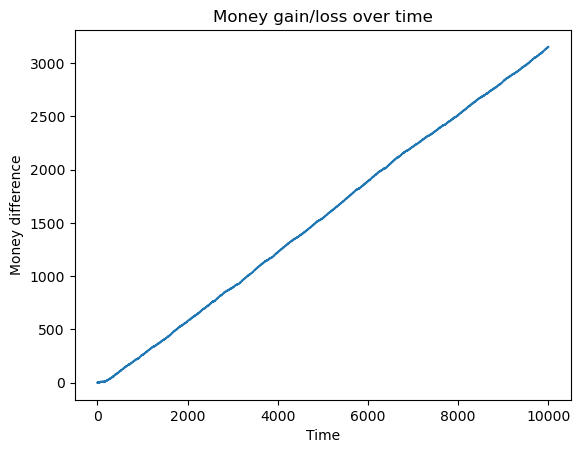

In [272]:
money_plot(rewards, price_per_play)

In [273]:
# variables
c = 0.9 # 0.8 is good
n_trials = 10000
initial_money = 5000

if n_trials * price_per_play > initial_money:
    raise Exception("Not enough money to play ! Decrease the number of trials")

In [274]:
def ucb_algorithm(n_arms, n_steps, c, p):
    # Initialize variables
    wins = np.zeros(n_arms)
    losses = np.zeros(n_arms)
    upper_bounds = np.ones(n_arms) * float('inf')
    lower_bounds = np.ones(n_arms) * float('-inf')
    selected_arms = np.zeros(n_steps)
    rewards = np.zeros(n_steps)
    
    counter = 0
    for step in range(n_steps):
        # Calculate upper confidence bounds for each arm
        for i in range(n_arms):
            if wins[i] + losses[i] > 0:
                p_i = wins[i] / (wins[i] + losses[i])
                upper_bounds[i] = p_i + c / np.sqrt(wins[i] + losses[i])
                lower_bounds[i] = p_i - c / np.sqrt(wins[i] + losses[i])
        
        # Select arm with highest upper confidence bound
        selected_arm = np.argmax(upper_bounds)
        selected_arms[counter] = selected_arm
        
        # Simulate play and update wins and losses
        if np.random.rand() < p[selected_arm]:  # simulate win with probability p_i
            wins[selected_arm] += 1
            rewards[counter] = 1
        else:
            losses[selected_arm] += 1
            rewards[counter] = 0   

    # Return selected arms at each step
    return selected_arms, rewards, wins, losses

In [275]:
selected_arms, rewards, wins, losses = ucb_algorithm(n_arms, n_trials, c, true_probs)

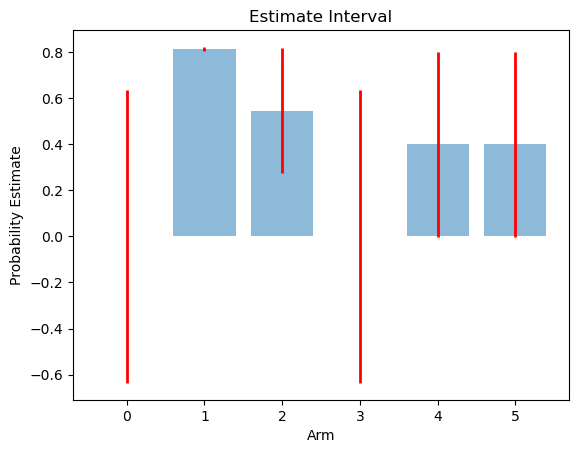

In [276]:
# estimate interval at the end 
plot_estimate_interval(n_arms, wins, losses, c)

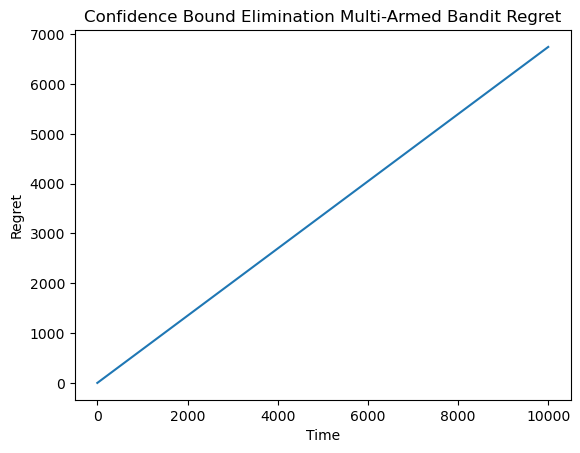

In [277]:
# Compute the regret
regret_vals = regret(selected_arms, true_probs)

# Plot the regret
line_plot(y_values=regret_vals, x_label="Time", y_label="Regret", title="Confidence Bound Elimination Multi-Armed Bandit Regret")

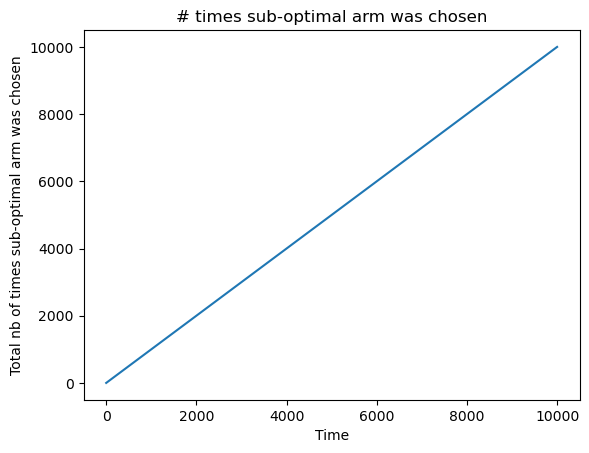

In [278]:
sub_optimal_arm_chosen_plot(p=true_probs, actions=selected_arms)

In [279]:
money_stats(initial_money, price_per_play, n_trials, reward, rewards)

Money initially : 5000
Money invested : 5000.0
Money gained : 1.0
Money difference : -4999.0
Money left : 1.0


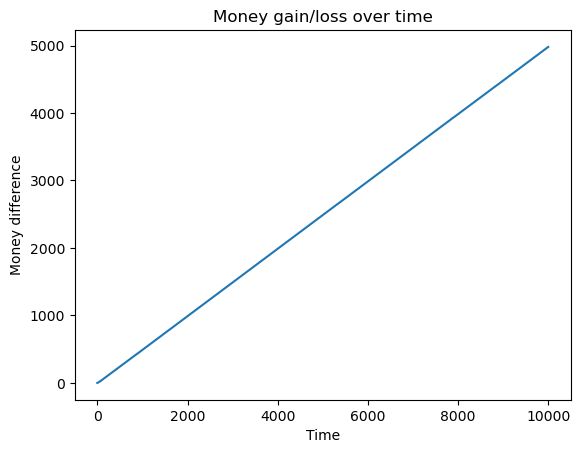

In [280]:
money_plot(rewards, price_per_play)

# Week 3